# Exercise: Spam Email Classification
Goal: Conduct a pipeline to convert each email into a feature vector. The pipeline should be able to  transform an email into a (sparse) vector that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, "Hello," "how," "are," "you," then the email "Hello you Hello Hello you" would be converted into a vector [1, 0, 0, 1] (meaning [“Hello" is present, "how" is absent, "are" is absent, "you" is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word.

### Data (spam and ham) is obtained from from Apache SpamAssassin's public datasets.

In [12]:
import tarfile
from pathlib import Path
import urllib.request

# Python built-in model for parsing handling email message
import email 
import email.policy

import numpy as np
from sklearn.model_selection import train_test_split

In [13]:
def get_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading....", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [14]:
ham_dir, spam_dir = get_data()

### Load all the emails

In [15]:
# Store spam and ham emails in lists
ham_files = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_files = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [16]:
len(ham_files)

2500

In [17]:
len(spam_files)

500

### Read emails frm the file and parse its content into emial message object

In [18]:
def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [19]:
ham_emails = [load_email(filepath) for filepath in ham_files]
spam_emails = [load_email(filepath) for filepath in spam_files]

### Let's look at one example of ham and one example of spam to see how they look like

In [20]:
# Ham email example
print(ham_emails[3].get_content().strip())

Klez: The Virus That Won't Die
 
Already the most prolific virus ever, Klez continues to wreak havoc.

Andrew Brandt
>>From the September 2002 issue of PC World magazine
Posted Thursday, August 01, 2002


The Klez worm is approaching its seventh month of wriggling across 
the Web, making it one of the most persistent viruses ever. And 
experts warn that it may be a harbinger of new viruses that use a 
combination of pernicious approaches to go from PC to PC.

Antivirus software makers Symantec and McAfee both report more than 
2000 new infections daily, with no sign of letup at press time. The 
British security firm MessageLabs estimates that 1 in every 300 
e-mail messages holds a variation of the Klez virus, and says that 
Klez has already surpassed last summer's SirCam as the most prolific 
virus ever.

And some newer Klez variants aren't merely nuisances--they can carry 
other viruses in them that corrupt your data.

...

http://www.pcworld.com/news/article/0,aid,103259,00.asp
____

In [21]:
# Spam email example
print(spam_emails[5].get_content().strip())

A POWERHOUSE GIFTING PROGRAM You Don't Want To Miss! 
 
  GET IN WITH THE FOUNDERS! 
The MAJOR PLAYERS are on This ONE
For ONCE be where the PlayerS are
This is YOUR Private Invitation

EXPERTS ARE CALLING THIS THE FASTEST WAY 
TO HUGE CASH FLOW EVER CONCEIVED
Leverage $1,000 into $50,000 Over and Over Again

THE QUESTION HERE IS:
YOU EITHER WANT TO BE WEALTHY 
OR YOU DON'T!!!
WHICH ONE ARE YOU?
I am tossing you a financial lifeline and for your sake I 
Hope you GRAB onto it and hold on tight For the Ride of youR life!

Testimonials

Hear what average people are doing their first few days:
�We've received 8,000 in 1 day and we are doing that over and over again!' Q.S. in AL
 �I'm a single mother in FL and I've received 12,000 in the last 4 days.� D. S. in FL
�I was not sure about this when I sent off my $1,000 pledge, but I got back $2,000 the very next day!� L.L. in KY
�I didn't have the money, so I found myself a partner to work this with. We have received $4,000 over the last 2 days

### Some emails have multipart, including images and attachments. Let's explore at the various types of structures that might be:

In [22]:
def get_email_structure(email):
    
    # Check if the email is string. 
    # If it's string, meaning the email is not parsed as an EmailMessage object, 
    # so it simply returns the string representation of the email.
    if isinstance(email, str):
        return email

    # Get content of email 
    content = email.get_payload()
    # if the content is a list, meaning the email message is multiparts
    if isinstance(content, list):
        multiparts = ", ".join([get_email_structure(sub_email)
                               for sub_email in content])
        
        return f"multipart({multiparts})"
    else:
        return email.get_content_type()

In [23]:
# Take a list of emial and display content structure within each email
def structures_counter(emails):
    structures = {}
    for email in emails:
        structure = get_email_structure(email)
        if structure in structures:
            structures[structure] += 1
        else:
            structures[structure] = 1
    return structures

In [24]:
structures_counter(ham_emails)

{'text/plain': 2408,
 'multipart(text/plain, application/pgp-signature)': 66,
 'multipart(text/plain, text/html)': 8,
 'multipart(text/plain, text/enriched)': 1,
 'multipart(text/plain, application/ms-tnef, text/plain)': 1,
 'multipart(text/plain)': 3,
 'multipart(text/plain, application/octet-stream)': 2,
 'multipart(text/plain, text/plain)': 4,
 'multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)': 1,
 'multipart(text/plain, video/mng)': 1,
 'multipart(text/plain, multipart(text/plain))': 1,
 'multipart(text/plain, application/x-pkcs7-signature)': 1,
 'multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)': 1,
 'multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))': 1,
 'multipart(text/plain, application/x-java-applet)': 1}

In [25]:
structures_counter(spam_emails)

{'text/html': 183,
 'text/plain': 218,
 'multipart(text/plain, application/octet-stream)': 1,
 'multipart(text/html)': 20,
 'multipart(text/plain, text/html)': 45,
 'multipart(text/plain)': 19,
 'multipart(text/html, text/plain)': 1,
 'multipart(text/html, application/octet-stream)': 2,
 'multipart(multipart(text/html))': 5,
 'multipart(text/plain, image/jpeg)': 3,
 'multipart(multipart(text/html), application/octet-stream, image/jpeg)': 1,
 'multipart(multipart(text/plain, text/html), image/gif)': 1,
 'multipart/alternative': 1}

From observation, the ham emails are more often plain text, while spam contains quite a lot of HTML.

### Now let's take a look at the email headers

In [26]:
for header, value in spam_emails[5].items():
    print(header, ":", value)

Return-Path : <Thecashsystem@firemail.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 3453043F99	for <zzzz@localhost>; Thu, 22 Aug 2002 11:58:24 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 16:58:24 +0100 (IST)
Received : from mailbox-13.st1.spray.net (mailbox-13.st1.spray.net [212.78.202.113])	by webnote.net (8.9.3/8.9.3) with ESMTP id QAA05573	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 16:55:29 +0100
Received : from freesource (user-24-214-168-210.knology.net [24.214.168.210])	by mailbox-13.st1.spray.net (Postfix) with ESMTP	id ADDD03E25C; Thu, 22 Aug 2002 17:50:55 +0200 (DST)
Message-ID : <413-220028422154219900@freesource>
X-Priority : 1
To : 1 <thecashsystem@firemail.de>
From : TheCashSystem <Thecashsystem@firemail.de>
Subject : RE: Your Bank Ac

In [27]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

### Feature Engineering
Using Bag-of-Words technique to convert email text into Bag-of-Words features

In [28]:
# Combine ham and spam emails into a single list
all_emails = ham_emails + spam_emails

X = np.array(all_emails, dtype=object)

# Create labels (0 for ham, 1 for spam)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

### Split it into a training set and a test set

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2400,) (600,) (2400,) (600,)


Okay, let's start writing the preprocessing functions. First, we will need a function to convert HTML to plain text. Arguably the best way to do this would be to use the great BeautifulSoup library, but I would like to avoid adding another dependency to this project, so let's hack a quick & dirty solution using regular expressions (at the risk of un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment). The following function first drops the <head> section, then converts all <a> tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities (such as &gt; or &nbsp;):

In [30]:
from bs4 import BeautifulSoup

def html_to_plain_text(html_content):
    # Parse the HTML content
    parsed_html = BeautifulSoup(html_content, 'html.parser')
    
    # Extract the plain text from the parsed HTML
    plain_text = parsed_html.get_text()
    
    return plain_text

In [31]:
# # We need a function to convert HTML to plain text
# import re
# from html import unescape

# def html_to_plain_text(html):
#     text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
#     text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
#     text = re.sub('<.*?>', '', text, flags=re.M | re.S)
#     text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
#     return unescape(text)

Let's see if it works. This is HTML spam:

In [32]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content())

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

**Let's convert all html to plain text**

In [33]:
print(html_to_plain_text(sample_html_spam.get_content())[:100], "...")




OTC

 Newsletter
Discover Tomorrow's Winners 

For Immediate Release

Cal-Bay (Stock Symbol: CBYI ...


**Now let's write a function that takes an email as input and returns all its content as plain text**

In [34]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: 
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [35]:
print(email_to_text(sample_html_spam)[:1000], "...")




OTC

 Newsletter
Discover Tomorrow's Winners 

For Immediate Release

Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.

REASONS TO INVEST IN CBYI

A profitable company and is on track to beat ALL earnings estimates!

One of the FASTEST growing distributors in environmental & safety equipment instruments.

Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.

RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as

**Let's use the Natural Language Toolkit (NLTK) too reduce words to their common base form**

In [36]:
import nltk

stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


**We need to replace URLs with the word "URL"**

In [37]:
import sys

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    %pip install -q -U urlextract

In [38]:
import urlextract 

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://www.youtube.com/watch?v=1OxtEEZum7I"
print(url_extractor.find_urls(some_text))

['github.com', 'https://www.youtube.com/watch?v=1OxtEEZum7I']


### Build Transformer to convert Email to Words Counter

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Let's try this transformer on a few emails

In [60]:
X_few = X_train[:2]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

### Build Transformer to convert Words Counter to Vector
Now we have the word counts, and we need to <u>convert them to vectors</u>. For this, we will build another transformer whose fit() method will build the vocabulary (an ordered list of the most common words) and whose transform() method will use the vocabulary to convert word counts to vectors. <u>The output is a sparse matrix</u>

In [64]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))

In [65]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<2x11 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [66]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [97, 11,  9,  8,  3,  3,  3,  3,  2,  2,  2]])

**Intepret matrix**
The 97 in the second row and first column, means that the second email contains 97 words that are not part of the vocabulary. The 11 next to it means that the first word in the vocabulary is present 11 times in this email. The 9 next to it means that the second word is present 9 times, and so on.

In [67]:
# Look at the vocabulary to know which words mentioned. 
# The first word is "the", the second word is "of", etc.
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'all': 4,
 'christian': 5,
 'to': 6,
 'by': 7,
 'jefferson': 8,
 'i': 9,
 'have': 10}

### Transform whole dataset

In [84]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)
X_test_transformed = preprocess_pipeline.transform(X_test)

### LogisticRegression

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
scores = cross_val_score(log_clf, X_train_transformed, y_train, cv=5, scoring='accuracy')
print("Accuracy scores for each fold:", scores)
print("Mean accuracy:", scores.mean())

Accuracy scores for each fold: [0.97708333 0.9875     0.98333333 0.98958333 0.98541667]
Mean accuracy: 0.9845833333333334


In [86]:
log_clf.fit(X_train_transformed, y_train)
y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

Precision: 93.94%
Recall: 97.89%


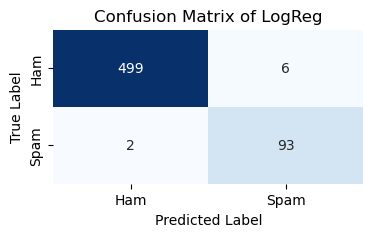

In [97]:
conf_matrix = confusion_matrix(y_test,y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix of LogReg')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Support Vector Machine

In [87]:
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings("ignore")

svc_clf = LinearSVC(max_iter=1000, random_state=42)
svc_scores = cross_val_score(svc_clf, X_train_transformed, y_train, cv=5, scoring='accuracy')

print("Accuracy scores for each fold:", svc_scores)
print("Mean accuracy:", svc_scores.mean())

Accuracy scores for each fold: [0.96041667 0.98333333 0.97708333 0.98333333 0.97708333]
Mean accuracy: 0.97625


In [88]:
svc_clf.fit(X_train_transformed, y_train)
svc_y_pred = svc_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, svc_y_pred):.2%}")
print(f"Recall: {recall_score(y_test, svc_y_pred):.2%}")

Precision: 89.90%
Recall: 93.68%


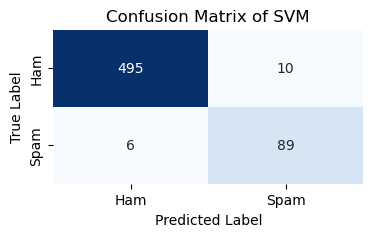

In [95]:
conf_matrix = confusion_matrix(y_test,svc_y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix of SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Neural Network

In [89]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(hidden_layer_sizes=(100, ), max_iter=1000, random_state=42)
mlp_scores = cross_val_score(mlp_clf, X_train_transformed, y_train, cv=5, scoring='accuracy')
print("Accuracy scores for each fold:", mlp_scores)
print("Mean accuracy:", mlp_scores.mean())

Accuracy scores for each fold: [0.97916667 0.98541667 0.98125    0.99166667 0.98958333]
Mean accuracy: 0.9854166666666666


In [90]:
mlp_clf.fit(X_train_transformed, y_train)
mlp_y_pred = mlp_clf.predict(X_test_transformed)
print(f"Precision: {precision_score(y_test, mlp_y_pred):.2%}")
print(f"Recall: {recall_score(y_test, mlp_y_pred):.2%}")

Precision: 97.87%
Recall: 96.84%


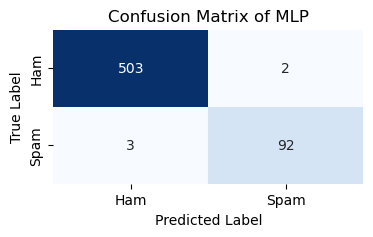

In [96]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, mlp_y_pred )

# Plot confusion matrix as a heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix of MLP')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
